# Info
Name:  

    ORACLES_SSFR_cloud_retrieval

Purpose:  

    Run the cloud retrieval on SSFR data from ORACLES 2016 and 2017, but only on the flagacaod times.
  
Input:

    none

Output:
   
    plots
    mat save files
  
Keywords:

    none
  
Dependencies:

    - numpy
    - matplotlib
    - scipy

  
Needed Files:

  - ...
    
History:

    Written: Samuel LeBlanc,Santa Cruz, CA, 2018-06-29

# Prepare the python environment

In [1]:
import numpy as np
import scipy.io as sio
import os
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
import load_utils as lu
import Sp_parameters as Sp

In [4]:
import hdf5storage as hs
from path_utils import getpath
from write_utils import nearest_neighbor
from tqdm import tqdm_notebook as tqdm
import math

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from scipy import interpolate

In [6]:
fp = getpath('ORACLES')
fp

Return path named:  ORACLES /mnt/c/Users/sleblanc/Research/ORACLES/


u'/mnt/c/Users/sleblanc/Research/ORACLES/'

# Load files

In [7]:
days = ['20160830','20160831','20160902','20160904','20160906','20160908',
       '20160910','20160912','20160914','20160918','20160920','20160924','20160925','20160927']

## Load the SSFR ict files for 2016

In [8]:
ssfr_a, ssfr_ah = [],[]
for d in days:
    sf,sfh = lu.load_ict(fp+'data_other/ssfr/SSFR_P3_{}_R1.ict'.format(d),return_header=True)
    ssfr_a.append(lu.recarray_to_dict(sf))
    ssfr_ah.append(sfh)

('Start_UTC', 'DN415', 'DN440', 'DN500', 'DN675', 'DN870', 'DN990', 'DN1020', 'DN1064', 'DN1250', 'DN1650', 'DN2100', 'UP415', 'UP440', 'UP500', 'UP675', 'UP870', 'UP990', 'UP1020', 'UP1064', 'UP1250', 'UP1650', 'UP2100', 'LON', 'LAT', 'ALT', 'PITCH', 'ROLL', 'HEAD')
('Start_UTC', 'DN415', 'DN440', 'DN500', 'DN675', 'DN870', 'DN990', 'DN1020', 'DN1064', 'DN1250', 'DN1650', 'DN2100', 'UP415', 'UP440', 'UP500', 'UP675', 'UP870', 'UP990', 'UP1020', 'UP1064', 'UP1250', 'UP1650', 'UP2100', 'LON', 'LAT', 'ALT', 'PITCH', 'ROLL', 'HEAD')
('Start_UTC', 'DN415', 'DN440', 'DN500', 'DN675', 'DN870', 'DN990', 'DN1020', 'DN1064', 'DN1250', 'DN1650', 'DN2100', 'UP415', 'UP440', 'UP500', 'UP675', 'UP870', 'UP990', 'UP1020', 'UP1064', 'UP1250', 'UP1650', 'UP2100', 'LON', 'LAT', 'ALT', 'PITCH', 'ROLL', 'HEAD')
('Start_UTC', 'DN415', 'DN440', 'DN500', 'DN675', 'DN870', 'DN990', 'DN1020', 'DN1064', 'DN1250', 'DN1650', 'DN2100', 'UP415', 'UP440', 'UP500', 'UP675', 'UP870', 'UP990', 'UP1020', 'UP1064', 'UP1

In [10]:
ssfr_ah[0]

['65, 1001\n',
 'Schmidt, Sebastian\n',
 'University of Colorado at Boulder \n',
 'SW Spectral Irradiance from P3 Solar Spectral Flux Radiometer \n',
 'ORACLES 2016\n',
 '1, 1 \n',
 '2016,08,30,     2017,06,29\n',
 '      1.00000 \n',
 'Start_UTC, seconds\n',
 '          28 \n',
 '1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1\n',
 '-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000\n',
 'DN415, W m^-2 nm^-1, Downward Shortwave Irradiance at 415.896 nm \n',
 'DN440, W m^-2 nm^-1, Downward Shortwave Irradiance at 439.204 nm \n',
 'DN500, W m^-2 nm^-1, Downward Shortwave Irradiance at 499.224 nm \n',
 'DN675, W m^-2 nm^-1, Downward Shortwave Ir

In [11]:
ssfr_a[0]

{'ALT': array([121.2090849, 119.8221336, 117.1023079, ..., 114.1239797,
        114.5526548, 115.0824574]),
 'DN1020': array([      nan,       nan,       nan, ..., 0.0999855, 0.1006262,
        0.1005478]),
 'DN1064': array([      nan,       nan,       nan, ..., 0.0892522, 0.0897707,
        0.0899797]),
 'DN1250': array([      nan,       nan,       nan, ..., 0.0533757, 0.054143 ,
        0.0542727]),
 'DN1650': array([      nan,       nan,       nan, ..., 0.0144294, 0.0148633,
        0.0149588]),
 'DN2100': array([nan, nan, nan, ..., nan, nan, nan]),
 'DN415': array([      nan,       nan,       nan, ..., 0.1980696, 0.1988715,
        0.200078 ]),
 'DN440': array([      nan,       nan,       nan, ..., 0.2150901, 0.2159437,
        0.2173994]),
 'DN500': array([      nan,       nan,       nan, ..., 0.2518312, 0.2532425,
        0.2545707]),
 'DN675': array([      nan,       nan,       nan, ..., 0.2351929, 0.235979 ,
        0.2376681]),
 'DN870': array([      nan,       nan,       nan,

## Load the 4STAR files with flagacaod

In [12]:
star_a, star_ah = [],[]
for d in days:
    sf,sfh = lu.load_ict(fp+'aod_ict/v8/4STAR-AOD_P3_{}_R3.ict'.format(d),return_header=True)
    star_a.append(lu.recarray_to_dict(sf))
    star_ah.append(sfh)

('Start_UTC', 'Latitude', 'Longitude', 'GPS_Alt', 'qual_flag', 'amass_aer', 'AOD_angstrom_470_865', 'AOD_polycoef_a2', 'AOD_polycoef_a1', 'AOD_polycoef_a0', 'AOD0355', 'AOD0380', 'AOD0452', 'AOD0470', 'AOD0501', 'AOD0520', 'AOD0530', 'AOD0532', 'AOD0550', 'AOD0606', 'AOD0620', 'AOD0660', 'AOD0675', 'AOD0700', 'AOD0781', 'AOD0865', 'AOD1020', 'AOD1040', 'AOD1064', 'AOD1236', 'AOD1250', 'AOD1559', 'AOD1627', 'AOD1650', 'UNCAOD0355', 'UNCAOD0380', 'UNCAOD0452', 'UNCAOD0470', 'UNCAOD0501', 'UNCAOD0520', 'UNCAOD0530', 'UNCAOD0532', 'UNCAOD0550', 'UNCAOD0606', 'UNCAOD0620', 'UNCAOD0660', 'UNCAOD0675', 'UNCAOD0700', 'UNCAOD0781', 'UNCAOD0865', 'UNCAOD1020', 'UNCAOD1040', 'UNCAOD1064', 'UNCAOD1236', 'UNCAOD1250', 'UNCAOD1559', 'UNCAOD1627', 'UNCAOD1650', 'flag_acaod')
('Start_UTC', 'Latitude', 'Longitude', 'GPS_Alt', 'qual_flag', 'amass_aer', 'AOD_angstrom_470_865', 'AOD_polycoef_a2', 'AOD_polycoef_a1', 'AOD_polycoef_a0', 'AOD0355', 'AOD0380', 'AOD0452', 'AOD0470', 'AOD0501', 'AOD0520', 'AOD05

('Start_UTC', 'Latitude', 'Longitude', 'GPS_Alt', 'qual_flag', 'amass_aer', 'flag_acaod', 'AOD_angstrom_470_865', 'AOD_polycoef_a2', 'AOD_polycoef_a1', 'AOD_polycoef_a0', 'AOD0355', 'AOD0380', 'AOD0452', 'AOD0470', 'AOD0501', 'AOD0520', 'AOD0530', 'AOD0532', 'AOD0550', 'AOD0606', 'AOD0620', 'AOD0660', 'AOD0675', 'AOD0700', 'AOD0781', 'AOD0865', 'AOD1020', 'AOD1040', 'AOD1064', 'AOD1236', 'AOD1250', 'AOD1559', 'AOD1627', 'AOD1650', 'UNCAOD0355', 'UNCAOD0380', 'UNCAOD0452', 'UNCAOD0470', 'UNCAOD0501', 'UNCAOD0520', 'UNCAOD0530', 'UNCAOD0532', 'UNCAOD0550', 'UNCAOD0606', 'UNCAOD0620', 'UNCAOD0660', 'UNCAOD0675', 'UNCAOD0700', 'UNCAOD0781', 'UNCAOD0865', 'UNCAOD1020', 'UNCAOD1040', 'UNCAOD1064', 'UNCAOD1236', 'UNCAOD1250', 'UNCAOD1559', 'UNCAOD1627', 'UNCAOD1650')
('Start_UTC', 'Latitude', 'Longitude', 'GPS_Alt', 'qual_flag', 'amass_aer', 'AOD_angstrom_470_865', 'AOD_polycoef_a2', 'AOD_polycoef_a1', 'AOD_polycoef_a0', 'AOD0355', 'AOD0380', 'AOD0452', 'AOD0470', 'AOD0501', 'AOD0520', 'AOD05

In [13]:
ssfr_a[3]['Start_UTC'][100]

7.578055555555555

In [14]:
star_ah[4]

['95, 1001\n',
 'Jens Redemann\n',
 'NASA Ames Research Center\n',
 'Spectrometers for Sky-Scanning, Sun-Tracking Atmospheric Research (4STAR)\n',
 'ORACLES 2016\n',
 '1, 1\n',
 '2016, 09, 06, 2018, 06, 22\n',
 '1\n',
 'Start_UTC, seconds, Elapsed seconds from 0 hours UT on day: 20160824\n',
 '58\n',
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1\n',
 ' -9999.0000000, -9999.0000000, -9999.0, -9999, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.000, -9999.00

## Get the flagacaod on the timescale of the ssfr measurements

In [15]:
for i,d in enumerate(days):
    fa = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['flag_acaod'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['flagacaod'] = fa
    am = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['amass_aer'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['airmass'] = am
    ssfr_a[i]['sza'] = np.arccos(1.0/am)*180.0/np.pi
    aod = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['AOD0501'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['AOD_500'] = aod
    a2 = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['AOD_polycoef_a2'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['a2'] = a2
    a1 = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['AOD_polycoef_a1'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['a1'] = a1
    a0 = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['AOD_polycoef_a0'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['a0'] = a0

In [16]:
ssfr_a[0]['flagacaod'].shape,ssfr_a[0]['Start_UTC'].shape

((4929,), (4929,))

## Load the LUT for 2wvl reflectance retrieval

In [30]:
lut = hs.loadmat(fp+'rtm/v5_irr_ORACLES_lut.mat')

In [31]:
lut.keys()

[u'tau',
 u'rad',
 u'lut_details',
 u'sza',
 u'irr_dn_diff',
 u'irr_dn',
 u'zout',
 u'wvl',
 u'phase',
 u'ref',
 u'irr_up']

## Combine into one array

In [17]:
nm = ssfr_a[1].keys()

In [18]:
ar = {}
for n in ssfr_a[1].keys():
    ar[n] = np.array([])

In [19]:
ar['days'] = np.array([])

In [20]:
for i,d in enumerate(days):
    ar['days'] = np.append(ar['days'],np.zeros_like(ssfr_a[i]['Start_UTC'])+i)
    for n in nm:
        try:
            ar[n] = np.append(ar[n],ssfr_a[i][n])
        except:
            print 'problem with :'+n
            ar[n] = np.append(ar[n],ssfr_a[i]['Start_UTC']*0)

# Format the LUT and data for retrievals

In [21]:
class so:
    pass

## Set up the data

In [22]:
ar['meas'] = so
ar['meas'].sza = ar['sza']
ar['meas'].Rvis = ar['UP500']/ar['DN500']
ar['meas'].Rnir = ar['UP1650']/ar['DN1650']
ar['meas'].utc = ar['Start_UTC']

In [23]:
# filter out the bad data. 
bad = (ar['meas'].Rvis > 1.0) & (ar['flagacaod']==0) & (ar['meas'].Rnir > 1.0)
ar['meas'].Rvis[bad] = np.nan
ar['meas'].Rvis[bad] = np.nan

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [24]:
igood = np.where((np.isfinite(ar['meas'].Rvis)) & (ar['meas'].Rvis > 0.0) & (np.isfinite(ar['meas'].Rnir)) & \
(ar['meas'].Rnir > 0.0) & (ar['flagacaod']==1))[0]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


## Plot the histogram of cloud reflectances

<IPython.core.display.Javascript object>


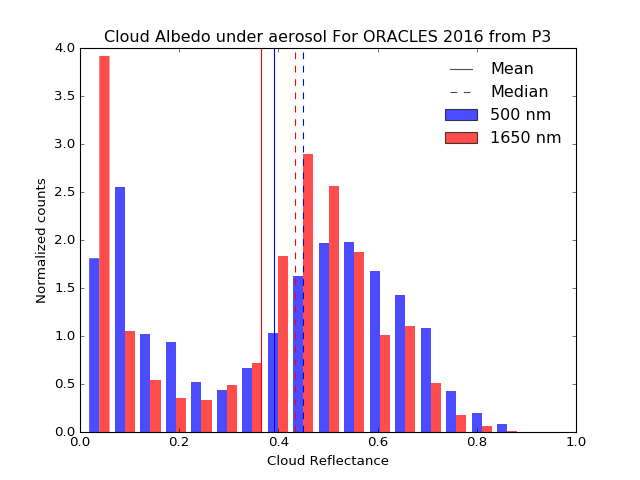

In [71]:
plt.figure()

plt.hist([ar['meas'].Rvis[igood],ar['meas'].Rnir[igood]],bins=30,edgecolor='None',color=['b','r'],alpha=0.7,normed=True,label=['500 nm','1650 nm'])

plt.ylabel('Normalized counts')
plt.xlabel('Cloud Reflectance')
plt.title('Cloud Albedo under aerosol For ORACLES 2016 from P3')
plt.xlim([0,1])


plt.axvline(np.nanmean(ar['meas'].Rvis[igood]),color='b')
plt.axvline(np.nanmedian(ar['meas'].Rvis[igood]),color='b',linestyle='--')
plt.axvline(np.nanmean(ar['meas'].Rnir[igood]),color='r')
plt.axvline(np.nanmedian(ar['meas'].Rnir[igood]),color='r',linestyle='--')

plt.axvline(-0.1,color='k',alpha=0.7,label='Mean')
plt.axvline(-0.1,color='k',alpha=0.7,linestyle='--',label='Median')

plt.legend(frameon=False)

plt.savefig(fp+'plot/Cloud_reflectance_ORACLES_2016.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


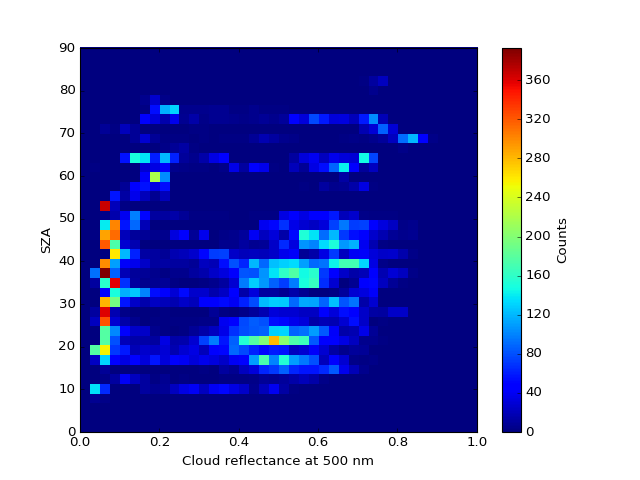

In [44]:
plt.figure()
plt.hist2d(ar['meas'].Rvis[igood],ar['meas'].sza[igood],bins=40,range=[[0,1],[0,90]])
plt.ylabel('SZA')
plt.xlabel('Cloud reflectance at 500 nm')
cb = plt.colorbar()
cb.set_label('Counts')
plt.savefig(fp+'plot/ORACLES_2016_2dhist_SZA_vs_cloud_refl500.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


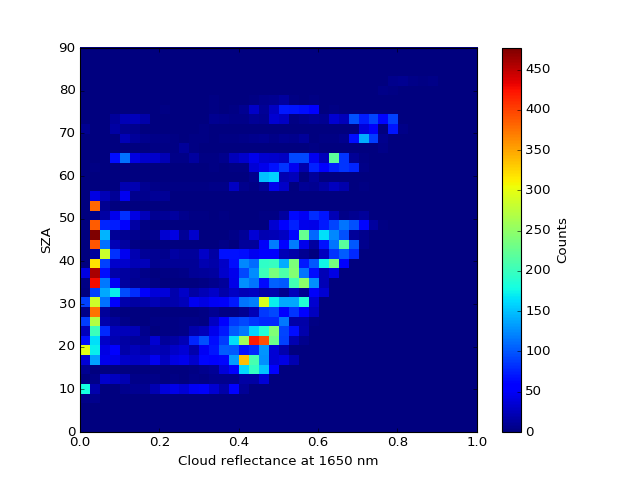

In [45]:
plt.figure()
plt.hist2d(ar['meas'].Rnir[igood],ar['meas'].sza[igood],bins=40,range=[[0,1],[0,90]])
plt.ylabel('SZA')
plt.xlabel('Cloud reflectance at 1650 nm')
cb = plt.colorbar()
cb.set_label('Counts')
plt.savefig(fp+'plot/ORACLES_2016_2dhist_SZA_vs_cloud_refl1650.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


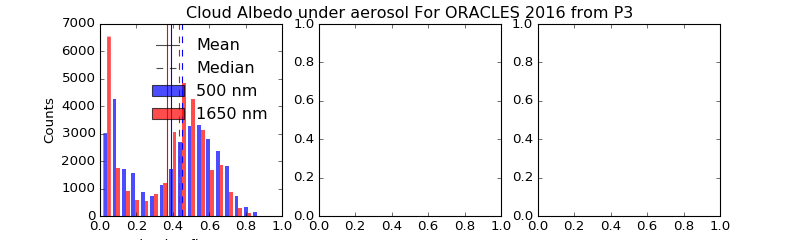

In [70]:
[fig, ax] = plt.subplots(1,3,figsize=(10,3))
ax[0].hist([ar['meas'].Rvis[igood],ar['meas'].Rnir[igood]],bins=30,edgecolor='None',color=['b','r'],alpha=0.7,label=['500 nm','1650 nm'])
ax[0].set_xlim(0,1)
ax[0].set_xlabel('Cloud Reflectance')
ax[0].set_ylabel('Counts')
ax[0].axvline(np.nanmean(ar['meas'].Rvis[igood]),color='b')
ax[0].axvline(np.nanmedian(ar['meas'].Rvis[igood]),color='b',linestyle='--')
ax[0].axvline(np.nanmean(ar['meas'].Rnir[igood]),color='r')
ax[0].axvline(np.nanmedian(ar['meas'].Rnir[igood]),color='r',linestyle='--')

ax[0].axvline(-0.1,color='k',alpha=0.7,label='Mean')
ax[0].axvline(-0.1,color='k',alpha=0.7,linestyle='--',label='Median')
ax[0].legend(frameon=False)

ax[1].set_title('Cloud Albedo under aerosol For ORACLES 2016 from P3')

In [ ]:
ax[0].

<IPython.core.display.Javascript object>


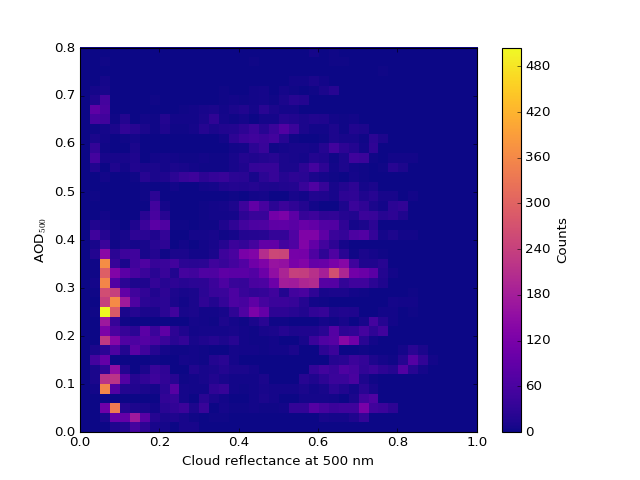

In [57]:
plt.figure()
plt.hist2d(ar['meas'].Rvis[igood],ar['AOD_500'][igood],bins=40,range=[[0,1],[0,0.8]],cmap=plt.cm.plasma)
plt.ylabel('AOD$_{{500}}$')
plt.xlabel('Cloud reflectance at 500 nm')
cb = plt.colorbar()
cb.set_label('Counts')

In [47]:
ar.keys()

['UP1250',
 'DN415',
 'UP500',
 'sza',
 'LON',
 'UP870',
 'AOD_500',
 'DN1650',
 'DN2100',
 'UP990',
 'flagacaod',
 'UP1064',
 'DN675',
 'UP415',
 'HEAD',
 'airmass',
 'UP1020',
 'UP2100',
 'meas',
 'DN500',
 'a1',
 'DN1020',
 'DN870',
 'DN440',
 'UP675',
 'DN1250',
 'a0',
 'UP440',
 'DN1064',
 'Start_UTC',
 'days',
 'UP1650',
 'a2',
 'PITCH',
 'LAT',
 'DN990',
 'ALT',
 'ROLL']

## set up the LUT

In [257]:
lut.keys()

[u'tau',
 u'rad',
 'ref_hi',
 'tau_hi',
 u'lut_details',
 'Rnir_hi',
 u'sza',
 'Rvis',
 u'irr_dn_diff',
 u'irr_dn',
 u'zout',
 'Rnir',
 u'wvl',
 u'phase',
 'Rvis_hi',
 u'ref',
 u'irr_up']

In [124]:
lut['tau'].shape, lut['ref'].shape, lut['sza'].shape, lut['irr_dn'].shape, lut['wvl'].shape, lut['zout'], lut['phase']

((27,), (23,), (48,), (1, 2, 3, 23, 27, 48), (2,), [0.2, 1.5, 100.0], ['wc'])

In [121]:
lut['Rvis'] = np.zeros([23,27,48])
lut['Rnir'] = np.zeros([23,27,48])

In [122]:
for ir,r in enumerate(lut['ref']):
    for it,t in enumerate(lut['tau']):
        for iz,s in enumerate(lut['sza']):
            lut['Rvis'][ir,it,iz] = lut['irr_up'][0,0,1,ir,it,iz]/lut['irr_dn'][0,0,1,ir,it,iz]
            lut['Rnir'][ir,it,iz] = lut['irr_up'][0,1,1,ir,it,iz]/lut['irr_dn'][0,1,1,ir,it,iz]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [126]:
lut['sza']

array([ 11.36487697,  20.83969366,  26.76550058,  31.2732978 ,
        34.94801372,  38.05665663,  40.74905438,  43.11972483,
        45.23300465,  47.13508975,  48.86048959,  50.43578157,
        51.88193569,  53.21582641,  54.451256  ,  55.5996703 ,
        56.67067347,  57.67240684,  58.61183354,  59.49495605,
        60.3269852 ,  61.11247301,  61.85541869,  62.55935386,
        63.22741194,  63.86238505,  64.46677106,  65.04281282,
        65.59253108,  66.11775223,  66.62013188,  67.10117502,
        67.56225324,  68.00461964,  68.4294217 ,  68.83771245,
        69.23046027,  69.60855741,  69.97282752,  70.32403224,
        70.6628771 ,  70.99001664,  71.30605908,  71.61157038,
        71.90707798,  72.193074  ,  72.47001827,  72.73834093])

### Make a hires version of the LUT

In [416]:
lut['tau_hi'] = np.hstack([np.arange(1.0,25,0.5),np.arange(25,50,1),np.arange(50,102.5,2.5)])
lut['ref_hi'] = np.hstack([np.arange(0,15,0.25),np.arange(15,30.5,0.5)])

In [417]:
len(lut['tau_hi']), len(lut['ref_hi'])

(94, 91)

In [418]:
lut['Rvis_hi'] = np.zeros([91,94,48])
lut['Rnir_hi'] = np.zeros([91,94,48])

In [419]:
for i,z in enumerate(lut['sza']):
    fv = interpolate.RectBivariateSpline(lut['ref'],lut['tau'],lut['Rvis'][:,:,i],kx=1,ky=1)
    lut['Rvis_hi'][:,:,i] = fv(lut['ref_hi'],lut['tau_hi'])
    fn = interpolate.RectBivariateSpline(lut['ref'],lut['tau'],lut['Rnir'][:,:,i],kx=1,ky=1)
    lut['Rnir_hi'][:,:,i] = fn(lut['ref_hi'],lut['tau_hi'])

<IPython.core.display.Javascript object>


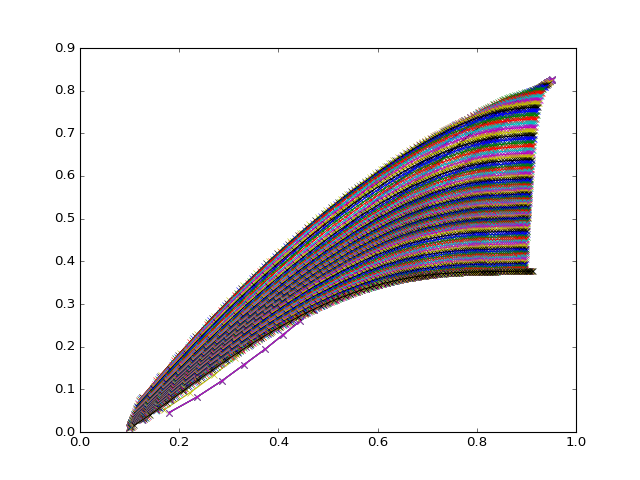

IndexError: index 91 is out of bounds for axis 0 with size 91

In [434]:
plt.figure()
for i,r in enumerate(lut['tau_hi']):
    plt.plot(lut['Rvis_hi'][i,:,0],lut['Rnir_hi'][i,:,0],'x-')

# Run the retrieval

In [420]:
ar['tau'], ar['ref'] = np.zeros_like(ar['sza'])*np.nan,np.zeros_like(ar['sza'])*np.nan

In [421]:
ar['ki'] = np.zeros_like(ar['sza'])

In [429]:
ar['isza'] = []

In [430]:
pbar = tqdm(total=len(ar['sza']))
for i,s in enumerate(ar['sza']):
    pbar.update()
    if (s>73.0) | (np.isnan(s)):
        continue
    if not i in igood:
        continue
    isza = np.argmin(np.abs(lut['sza']-s))
    ar['isza'].append(isza)
    ki = (ar['meas'].Rvis[i]-lut['Rvis_hi'][:,:,isza]/ar['meas'].Rvis[i])**2+(ar['meas'].Rnir[i]-lut['Rnir_hi'][:,:,isza]/ar['meas'].Rnir[i])**2
    kimin = np.unravel_index(np.nanargmin(ki),ki.shape)
    ar['ki'][i] = np.nanmin(ki)
    ar['tau'][i],ar['ref'][i] = lut['tau_hi'][kimin[1]],lut['ref_hi'][kimin[0]]

HBox(children=(IntProgress(value=0, max=380923), HTML(value=u'')))

<IPython.core.display.Javascript object>


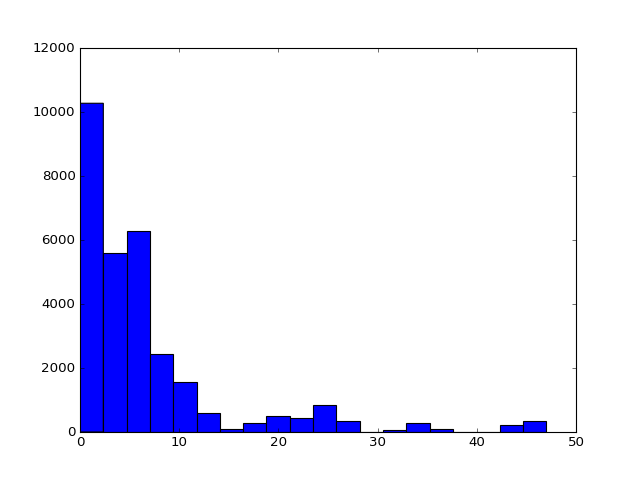

(array([  1.02730000e+04,   5.58800000e+03,   6.28300000e+03,
          2.43600000e+03,   1.57500000e+03,   5.97000000e+02,
          9.90000000e+01,   2.90000000e+02,   5.00000000e+02,
          4.22000000e+02,   8.47000000e+02,   3.46000000e+02,
          3.00000000e+00,   7.50000000e+01,   2.89000000e+02,
          8.10000000e+01,   8.00000000e+00,   0.00000000e+00,
          2.23000000e+02,   3.35000000e+02]),
 array([  0.  ,   2.35,   4.7 ,   7.05,   9.4 ,  11.75,  14.1 ,  16.45,
         18.8 ,  21.15,  23.5 ,  25.85,  28.2 ,  30.55,  32.9 ,  35.25,
         37.6 ,  39.95,  42.3 ,  44.65,  47.  ]),
 <a list of 20 Patch objects>)

In [432]:
plt.figure()
plt.hist(ar['isza'],bins=20)

# Plot the retrieval results

<IPython.core.display.Javascript object>


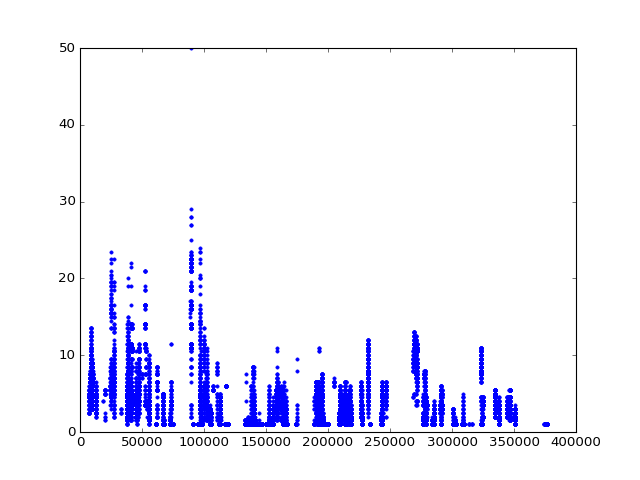

In [423]:
plt.figure()
plt.plot(ar['tau'],'.')

In [426]:
np.nanmean(ar['tau'])

2.8096465147010243

<IPython.core.display.Javascript object>


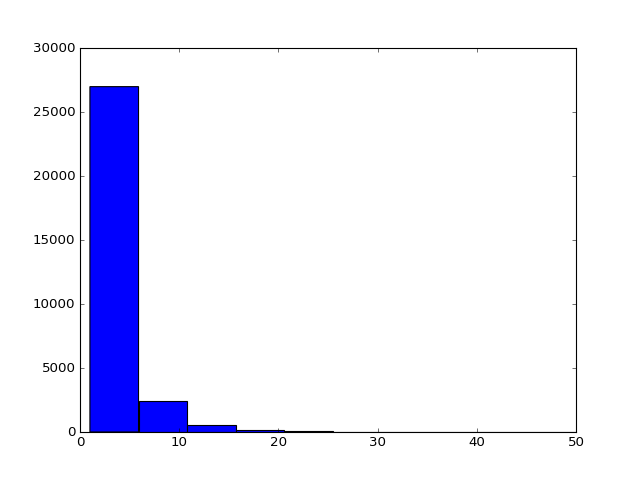

(array([  2.69810000e+04,   2.44900000e+03,   5.85000000e+02,
          1.74000000e+02,   7.50000000e+01,   5.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1. ,   5.9,  10.8,  15.7,  20.6,  25.5,  30.4,  35.3,  40.2,
         45.1,  50. ]),
 <a list of 10 Patch objects>)

In [427]:
plt.figure()
plt.hist(ar['tau'][np.isfinite(ar['tau'])])

<IPython.core.display.Javascript object>


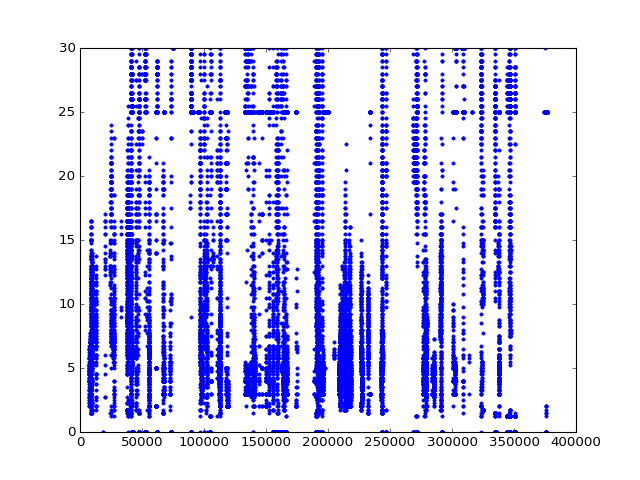

In [216]:
plt.figure()
plt.plot(ar['ref'],'.')

In [424]:
len(np.where(np.isfinite(ar['ref']))[0])

30270

In [425]:
len(ar['ref'])

380923

<IPython.core.display.Javascript object>


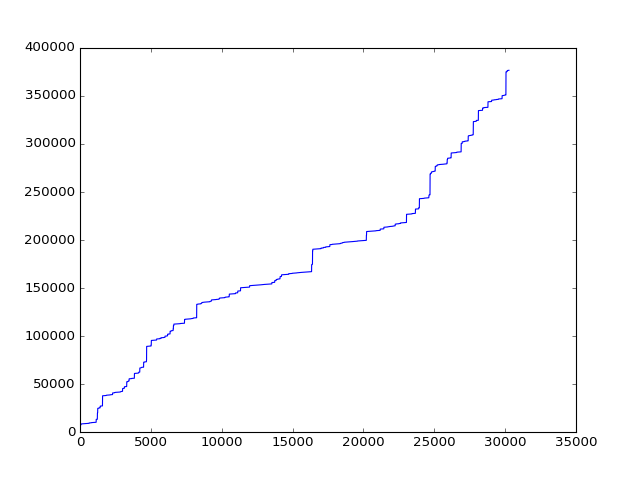

In [269]:
plt.figure()
plt.plot(np.where(np.isfinite(ar['ref']))[0])

# Save the retrieved output

In [263]:
out = {}

In [264]:
ar.keys()

['tau',
 'UP1250',
 'DN415',
 'UP500',
 'sza',
 'LON',
 'UP870',
 'AOD_500',
 'ki',
 'DN1650',
 'DN2100',
 'flagcaod',
 'UP990',
 'flagacaod',
 'UP1064',
 'DN675',
 'ref',
 'UP415',
 'HEAD',
 'airmass',
 'UP1020',
 'UP2100',
 'UP675',
 'DN500',
 'a1',
 'DN1020',
 'DN870',
 'DN440',
 'flacaod',
 'meas',
 'DN1250',
 'a0',
 'UP440',
 'DN1064',
 'Start_UTC',
 'days',
 'UP1650',
 'a2',
 'PITCH',
 'LAT',
 'DN990',
 'ALT',
 'ROLL']

In [265]:
out['tau'] = ar['tau']
out['ref'] = ar['ref']
out['sza'] = ar['sza']
out['aod'] = ar['AOD_500']
out['days'] = ar['days']
out['utc'] = ar['Start_UTC']
out['lat'] = ar['LAT']
out['lon'] = ar['LON']
out['a0'],out['a1'],out['a2'] = ar['a0'],ar['a1'],ar['a2']

In [266]:
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

In [267]:
hs.savemat(fp+'data_other/ssfr_2016_retrieved_COD.mat',out)

In [268]:
out['days']

array([  0.,   0.,   0., ...,  13.,  13.,  13.])

# Load the results of the CRE calculations
See the ORACLES_cld_CRE_from_SSFR jupyter notebook for details

In [273]:
c = hs.loadmat(fp+'rtm/ORACLES_CRE_v6_irr.mat')

In [274]:
c.keys()

[u'ssfr_aero_CRE', u'ssfr_aero_CRE_clear', u'ssfr_aero_C']

In [276]:
c['ssfr_aero_CRE'].keys()

[u'dn', u'up']

In [277]:
CRE_toa = c['ssfr_aero_CRE']['up'][:,2]-c['ssfr_aero_CRE_clear']['up'][:,2]

In [282]:
flt = np.isfinite(out['aod']) & (CRE_toa>0.0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [294]:
out['days']

array([  0.,   0.,   0., ...,  13.,  13.,  13.])

<IPython.core.display.Javascript object>


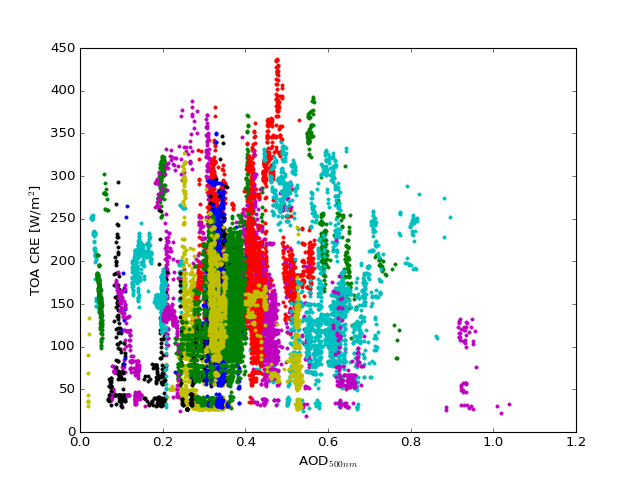

In [295]:
plt.figure()
for i in np.unique(out['days']):
    fi = np.where((flt==1) & (i==out['days']))
    plt.plot(out['aod'][fi],CRE_toa[fi],'.')
plt.xlabel('AOD$_{{500nm}}$')
plt.ylabel('TOA CRE [W/m$^2$]')

<IPython.core.display.Javascript object>


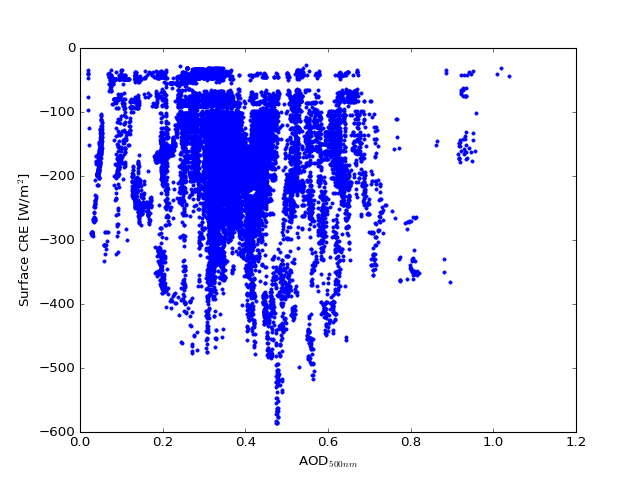

In [284]:
plt.figure()
plt.plot(out['aod'][flt],c['ssfr_aero_C'][flt,0],'.')
plt.xlabel('AOD$_{{500nm}}$')
plt.ylabel('Surface CRE [W/m$^2$]')

<IPython.core.display.Javascript object>


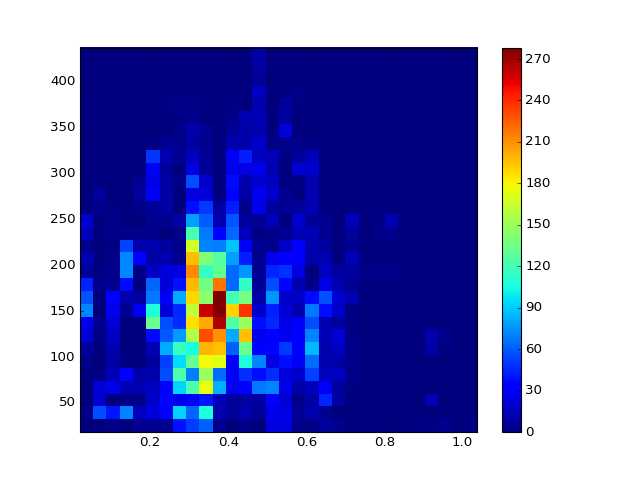

In [293]:
plt.figure()
plt.cm.viridis
plt.hist2d(out['aod'][flt],CRE_toa[flt],bins=30)
plt.colorbar()

In [300]:
import seaborn as sns
import plotting_utils as pu

<IPython.core.display.Javascript object>


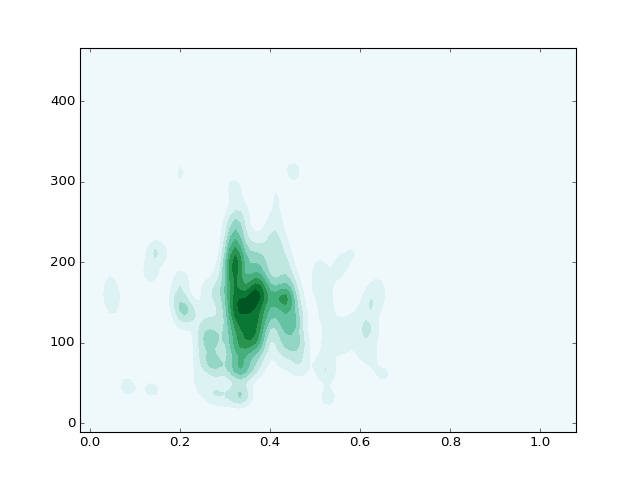

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [299]:
plt.figure()
#plt.hexbin(out['aod'][flt],CRE_toa[flt])
sns.kdeplot(out['aod'][flt],CRE_toa[flt], shade=True)

<IPython.core.display.Javascript object>


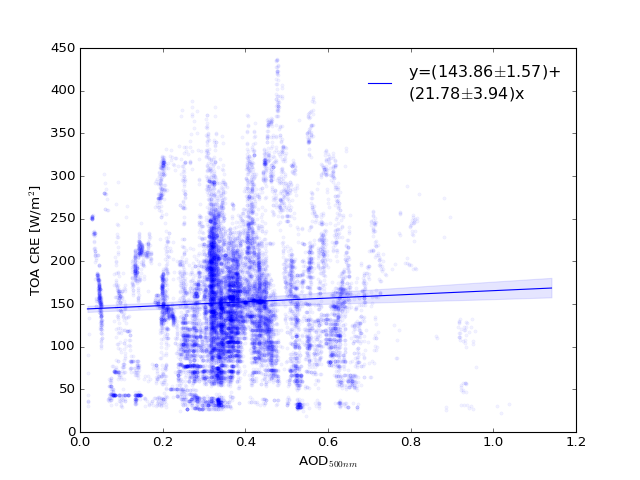

In [307]:
plt.figure()
plt.plot(out['aod'][flt],CRE_toa[flt],'.',alpha=0.05)
pu.plot_lin(out['aod'][flt],CRE_toa[flt])
plt.legend(frameon=False)
plt.xlabel('AOD$_{{500nm}}$')
plt.ylabel('TOA CRE [W/m$^2$]')

<IPython.core.display.Javascript object>


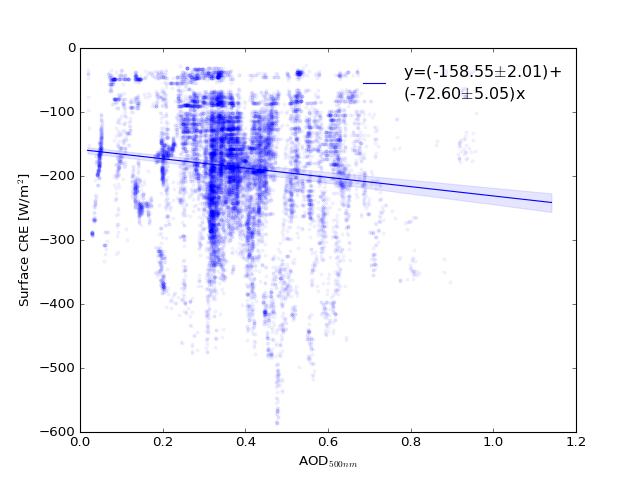

In [308]:
plt.figure()
plt.plot(out['aod'][flt],c['ssfr_aero_C'][flt,0],'.',alpha=0.05)
pu.plot_lin(out['aod'][flt],c['ssfr_aero_C'][flt,0])
plt.legend(frameon=False)
plt.xlabel('AOD$_{{500nm}}$')
plt.ylabel('Surface CRE [W/m$^2$]')

<IPython.core.display.Javascript object>


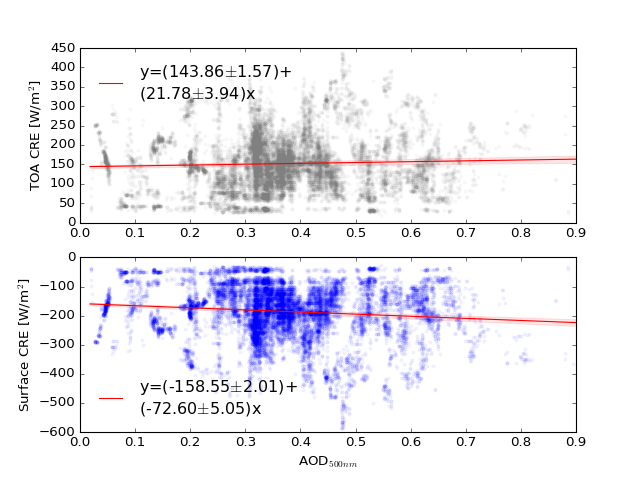

(0, 0.9)

In [324]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(out['aod'][flt],CRE_toa[flt],'.',color='grey',alpha=0.05)
pu.plot_lin(out['aod'][flt],CRE_toa[flt],color='r')
plt.legend(frameon=False,loc=2)
plt.ylabel('TOA CRE [W/m$^2$]')
plt.xlim(0,.9)

ax2 = plt.subplot(2,1,2)
plt.plot(out['aod'][flt],c['ssfr_aero_C'][flt,0],'.',color='blue',alpha=0.05)
pu.plot_lin(out['aod'][flt],c['ssfr_aero_C'][flt,0],color='r')
plt.legend(frameon=False,loc=3)
plt.xlabel('AOD$_{{500nm}}$')
plt.ylabel('Surface CRE [W/m$^2$]')
plt.xlim(0,.9)

In [325]:
rCRE_toa = CRE_toa/c['ssfr_aero_CRE']['dn'][:,2]*100.0
rCRE_sur = c['ssfr_aero_C'][:,0]/c['ssfr_aero_CRE']['dn'][:,2]*100.0

<IPython.core.display.Javascript object>


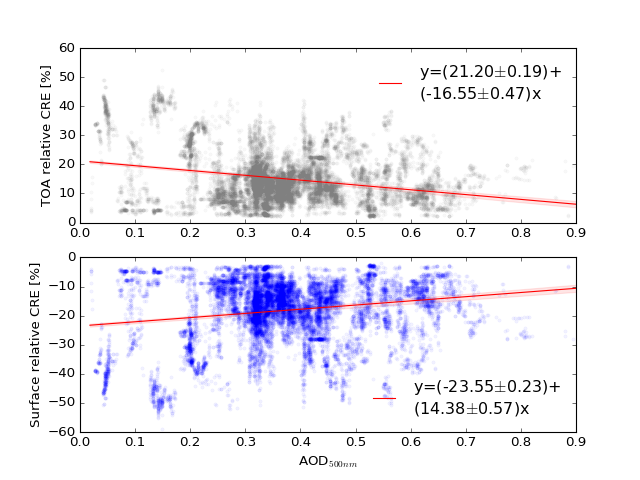

(0, 0.9)

In [328]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(out['aod'][flt],rCRE_toa[flt],'.',color='grey',alpha=0.05)
pu.plot_lin(out['aod'][flt],rCRE_toa[flt],color='r',ci=0.99)
plt.legend(frameon=False,loc=1)
plt.ylabel('TOA relative CRE [%]')
plt.xlim(0,.9)

ax2 = plt.subplot(2,1,2)
plt.plot(out['aod'][flt],rCRE_sur[flt],'.',color='blue',alpha=0.05)
pu.plot_lin(out['aod'][flt],rCRE_sur[flt],color='r',ci=0.99)
plt.legend(frameon=False,loc=4)
plt.xlabel('AOD$_{{500nm}}$')
plt.ylabel('Surface relative CRE [%]')
plt.xlim(0,.9)

In [330]:
help(pu.make_boxplot)

Help on function make_boxplot in module plotting_utils:

make_boxplot(vals, val_lim, lims, pos, color='green', label=None, y=0, alpha=1.0, ax=None, vert=True, fliers_off=False)
    Compile the functions to make a box plot
    
    vals: values to box
    val_lim: values to use as basis for binning
    lims: limits of the bins to use
    pos: center position of the limites
    y:?
    vert: (default True) if True, return vertical boxes, false for horizontal boxes
    fliers_off: (default False) if True, turns off the plotting of the outliers



In [337]:
lims = np.arange(0,1.3,0.1)
pos = np.arange(0.05,1.2,0.1)

In [339]:
lims,pos,len(lims),len(pos)

(array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2]),
 array([ 0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,  0.85,
         0.95,  1.05,  1.15]),
 13,
 12)

In [362]:
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

<IPython.core.display.Javascript object>


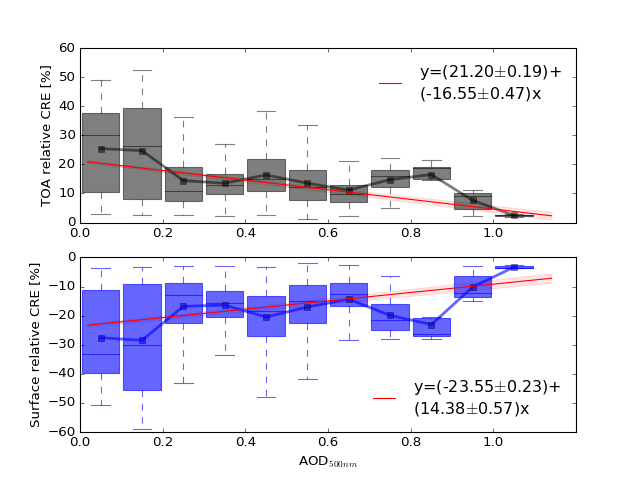

In [404]:
plt.figure()
ax1 = plt.subplot(2,1,1)
pu.make_boxplot(rCRE_toa[flt],out['aod'][flt],lims,pos,color='k',fliers_off=True,widths=0.09,patch_artist=True,alpha=0.5)
pu.plot_lin(out['aod'][flt],rCRE_toa[flt],color='r',ci=0.99,zorder=200)
plt.xlim(0.0,1.2)
plt.legend(frameon=False,loc=1)
plt.ylabel('TOA relative CRE [%]')

ax2 = plt.subplot(2,1,2)
pu.make_boxplot(rCRE_sur[flt],out['aod'][flt],lims,pos,color='blue',fliers_off=True,widths=0.09,patch_artist=True,alpha=0.6)
pu.plot_lin(out['aod'][flt],rCRE_sur[flt],color='r',ci=0.99,zorder=200)
plt.xlim(0.0,1.2)
plt.legend(frameon=False,loc=4)
plt.ylabel('Surface relative CRE [%]')
plt.xlabel('AOD$_{{500nm}}$')
plt.savefig(fp+'plot/SSFR_CRE_vs_AOD.png',transparent=True,dpi=600)

In [387]:
flo = (flt==1) & (out['tau']>0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


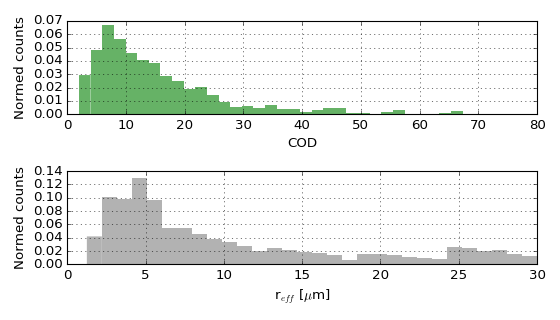

In [446]:
plt.figure(figsize=(7,4))
plt.subplot(2,1,1)
plt.hist(out['tau'][flo]*4.0,normed=True,edgecolor='None',color='g',alpha=0.6,bins=100)
plt.xlabel('COD')
plt.xlim(0,80)
plt.ylabel('Normed counts')
plt.grid()

plt.subplot(2,1,2)
plt.hist(out['ref'][flo],normed=True,edgecolor='None',color='grey',alpha=0.6,bins=30)
plt.xlabel('r$_{{eff}}$ [$\mu$m]')
plt.ylabel('Normed counts')
plt.grid()
plt.xlim(0,30)
plt.tight_layout()
plt.savefig(fp+'plot/SSFR_COD_ref_ORACLES2016_flagacaod.png',transparent=True,dpi=600)

In [445]:
np.nanmean(out['tau'][flo]*4.0)

15.043258528367728

In [408]:
import scipy.stats as st

In [449]:
a,xe,ye,bn = st.binned_statistic_2d(out['lat'][flo],out['lon'][flo],out['tau'][flo]*4.0,
                           bins=26,range=[[-25,-8],[0,16]],statistic='mean')
a = np.ma.masked_array(a,np.isnan(a))

<IPython.core.display.Javascript object>


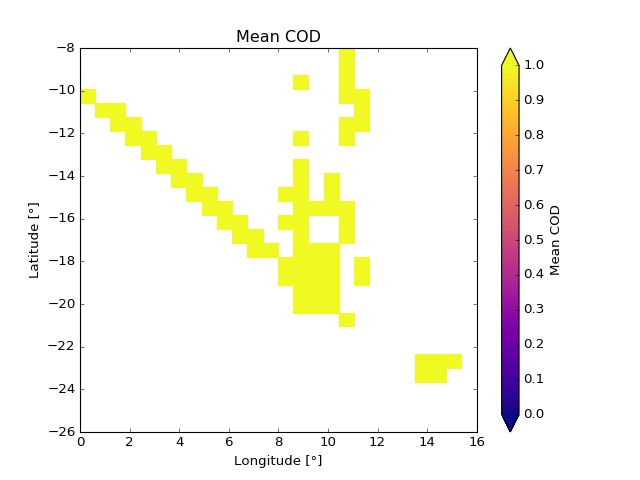

In [450]:
plt.figure()
p = plt.pcolor(ye,xe,a,vmin=0.0,vmax=1.0,cmap='plasma')

plt.xlabel(u'Longitude [°]')
plt.ylabel(u'Latitude [°]')
plt.title('Mean COD')

cb = plt.colorbar(p,extend='both')
cb.set_label('Mean COD')

In [405]:
np.nanmean(out['tau'][flo])

3.760814632091932

In [406]:
np.nanmean(out['ref'][flo])

10.23840322483605

In [394]:
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'